# Dependencies

In [1]:
import pkg_resources
import sys
import subprocess

# List of required packages (use package names as recognized by pip)
required = {
    'geopandas',
    'osmnx',
    'contextily',
    'libpysal',
    'esda',
    'pointpats',
    'matplotlib',
    'seaborn',
    'scikit-learn'
}

# Get the set of installed packages
installed = {pkg.key for pkg in pkg_resources.working_set}
# Determine which packages are missing
missing = required - installed

if missing:
    print(f"Installing missing packages: {missing}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
else:
    print("All required packages are already installed.")


All required packages are already installed.


# Python imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
from shapely.geometry import Point, Polygon
from shapely.wkt import loads
from libpysal.weights import Queen
from esda import Moran, Moran_Local
from sklearn.cluster import DBSCAN, KMeans
import os
import re
import json

# Crime data collection

In [3]:
data_path = "./data/NYPD_Complaint_Data_Historic.csv"
url = "https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD"

# columns to load
cols = ["CMPLNT_FR_DT", "LAW_CAT_CD", "BORO_NM", "ADDR_PCT_CD", "Latitude", "Longitude"]

# Check if the file exists locally
if os.path.exists(data_path):
    print("Loading data from local file...")
    crime_df = pd.read_csv(data_path, usecols=cols)
else:
    print("Downloading data from API...")
    crime_df = pd.read_csv(url, usecols=cols)
    # Save the fetched data to a local CSV file for future use
    crime_df.to_csv(data_path, index=False)

# Convert dates to datetime. Parse errors will set value to NaT
crime_df["CMPLNT_FR_DT"] = pd.to_datetime(crime_df["CMPLNT_FR_DT"], format="%m/%d/%Y", errors='coerce')

# Filter for year 2019
crime_df = crime_df[crime_df["CMPLNT_FR_DT"].dt.year == 2019]

# Drop records with missing or invalid coordinates
crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])
crime_df = crime_df[crime_df["Latitude"] != 0]

print(f"Total records in 2019: {len(crime_df)}")
crime_df.head(3)


Loading data from local file...
Total records in 2019: 459296


,CMPLNT_FR_DT,ADDR_PCT_CD,LAW_CAT_CD,BORO_NM,Latitude,Longitude
73179,2019-09-30,106.0,FELONY,QUEENS,40.674100,-73.844419
2356244,2019-11-01,61.0,VIOLATION,BROOKLYN,40.585029,-73.933156
2416574,2019-12-14,47.0,FELONY,BRONX,40.887049,-73.867793


# Amenities data collection

In [ ]:
data_path_amenities = "./data/NYC_Amenities.csv"

# Function to extract coordinates from Point objects or calculate centroid for Polygons
def extract_coordinates(geometry):
    if isinstance(geometry, Point):
        return geometry.x, geometry.y
    elif isinstance(geometry, Polygon):
        centroid = geometry.centroid
        return centroid.x, centroid.y
    return None, None

# Apply the function to the dataset
if os.path.exists(data_path_amenities):
    print("Loading amenities data from local file...")
    amenities_df = pd.read_csv(data_path_amenities, low_memory=False)
else:
    print("Querying OSM for amenities data...")
    # Define a dictionary of tags for the amenities you're interested in
    tags = {
        "amenity": ["bar", "restaurant"],
        "leisure": "park",
        "railway": "station"
    }

    # Use OSMnx to query OSM for these features in New York City
    amenities_gdf = ox.features.features_from_place("New York City, USA", tags)

    # Extract coordinates or calculate centroid
    amenities_gdf[['Longitude', 'Latitude']] = amenities_gdf['geometry'].apply(lambda x: pd.Series(extract_coordinates(x)))

    # Save the queried data to a CSV file for future use
    amenities_gdf.to_csv(data_path_amenities, index=False)
    amenities_df = amenities_gdf

    # Display the first few rows of the DataFrame
    amenities_df.head(3)


Querying OSM for amenities data...


# Plot Amenities

Unique leisure types: [nan 'park' 'amusement_arcade' 'dance' 'music']
Unique amenity types: [nan 'restaurant' 'bar' 'fountain']
Unique railway types: ['station' nan]
Number of station: 551
Number of park: 2054
Number of restaurant: 7532
Number of bar: 1330
Number of amusement_arcade: 13
Number of dance: 9
Number of music: 1


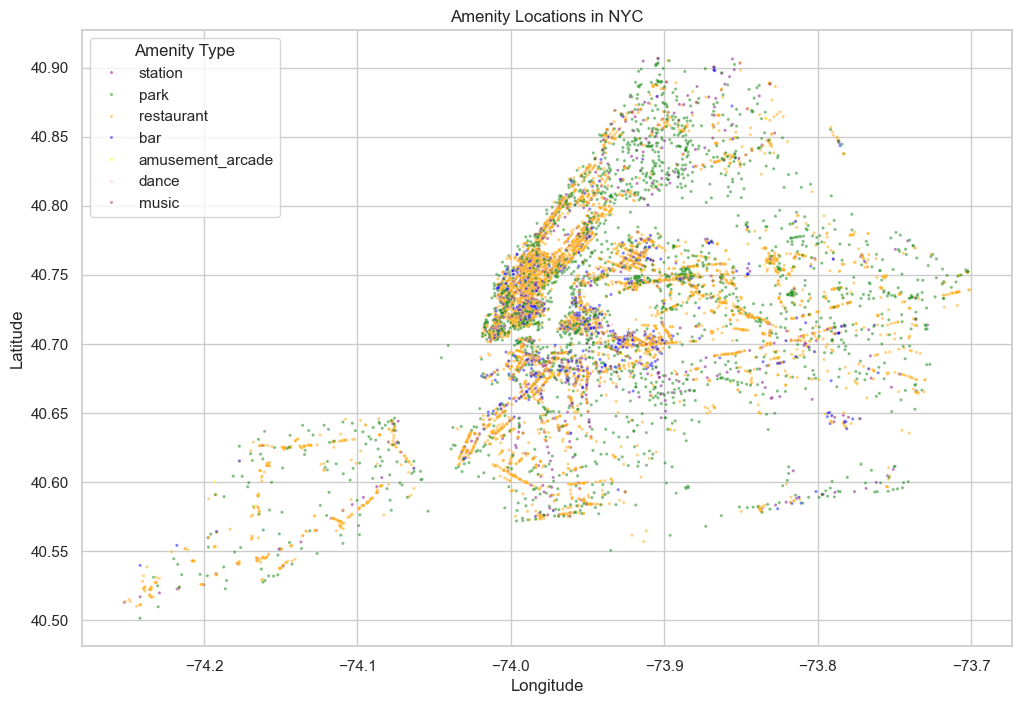

In [31]:
# Check unique values in the 'leisure' and 'amenity' columns
print("Unique leisure types:", amenities_df["leisure"].unique())
print("Unique amenity types:", amenities_df["amenity"].unique())
print("Unique railway types:", amenities_df["railway"].unique())

# Create a new column 'category' to combine 'leisure' and 'amenity'
amenities_df['category'] = amenities_df['leisure'].combine_first(amenities_df['amenity']).combine_first(amenities_df['railway'])

# Print the number of each amenity type
for amenity in amenities_df['category'].unique():
    print(f"Number of {amenity}: {len(amenities_df[amenities_df['category'] == amenity])}")

# Define colors for each category type
colors = {
    "bar": "blue",
    "restaurant": "orange",
    "park": "green",
    "station": "purple",
    "fountain": "red",
    'amusement_arcade': "yellow", 
    'music': 'brown', 
    'dance': 'pink',
    "railway": "cyan"
}

# Scatter plot of the amenities using the 'category' column for hue
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=amenities_df, x="Longitude", y="Latitude", hue="category", palette=colors, alpha=0.5, s=5)
plt.title("Amenity Locations in NYC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Amenity Type")
plt.show()

# Population by Neighbourhood tabulation areas (NTA) data

In [2]:
data_path_ntas = "./data/NYC_NTA.csv"

# Check if the file exists locally
if os.path.exists(data_path_ntas):
    print("Loading NTA data from local file...")
    nta_df = pd.read_csv(data_path_ntas, low_memory=False)

else:
    print("Downloading NTA data from API...")
    nta_url = "https://data.cityofnewyork.us/resource/swpk-hqdp.json"
    nta_df = pd.read_csv(nta_url, low_memory=False)
    # Save the fetched data to a local CSV file for future use
    nta_df.to_csv(data_path_ntas, index=False)